## Testing ADM+ on logo experiment with both views missing

In [7]:
### Import relevant libraries
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import cv2
import scipy as sci
import tqdm
import os
from scipy import ndimage
import helper_functions.plotting_funcs as plot_funcs
from helper_functions.logo_funcs import imresize_pad, lin2circ_angles, get_validation_indices, image_align_height
import json
import pickle

from helper_functions.embed_both_views import (ADMPlusConfig, ADM_PLUS,
                                               APMC, APMCConfig) 

sim_params = {
        'delete_kernels': False,
        'generate_data': False,
        'evd_solver': 'arpack',  # 'arpack' / 'randomized' / 'svd'
        'ad_methods': ['apmc', 'adm_plus'],
        'embed_dim': 2,
        't': 0,
        'scales': [0.5, 1, 2, 3, 4, 5, 6, 8, 10 ,20],
        # 'scales': [10],
        'im_resize_factor': 2.5,
        'missing_ratio': 0.7,  # number of samples in the reference set,
        'N' : 1000, # number of total samples
        'valid_size': 0.2,
        'data_path': 'logo_data'
    }

fig_str = f"figures/new_logo/two_views/missing_ratio_{sim_params['missing_ratio']}".replace('.', 'p')
# figures_path = f"{fig_str}_{sim_params['N']}"
figures_path = f"{fig_str}"
os.makedirs(figures_path, exist_ok=True)
N = sim_params['N']

# save params to json
with open(f"{figures_path}/sim_params.json", 'w') as fp:
    json.dump(sim_params, fp, indent=4)

In [8]:
font_name = "Times New Roman"  # Change to any other installed serif font if needed

# Set font properties using the font name
# 2 plots at a row 
font_properties_title = font_manager.FontProperties(family=font_name, size=28)
font_properties_ticks = font_manager.FontProperties(family=font_name, size=22)
figsize = (8, 7) 
# 3 plots in a row 
# font_properties_title = font_manager.FontProperties(family=font_name, size=38)
# font_properties_ticks = font_manager.FontProperties(family=font_name, size=32)
# figsize = (8, 7)  # 2 plot size

## Load Images

In [9]:
def process_images(img_view1, img_view2, img_common):
    height = 400 # height needs to be uniform for concatanation
    
    img_view1_rs = image_align_height(img_view1, height=height)
    img_common_rs = image_align_height(img_common, height=height)
    img_view2_rs = image_align_height(img_view2, height=height)
    
    return img_view1_rs, img_view2_rs, img_common_rs
    

Text(0.5, 1.0, 'View2 Logo')

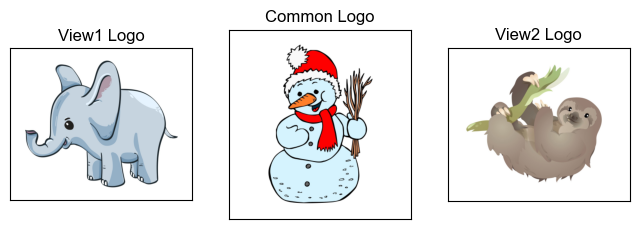

In [10]:
## Load Logo images 
# view1 logo
img = cv2.imread(f'{sim_params["data_path"]}/elephant.jpg', cv2.IMREAD_UNCHANGED)
img_view1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_view1_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# M&M logo
img = cv2.imread(f'{sim_params["data_path"]}/snowman.jpg')
img_common = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_common_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Starbucks logo
img = cv2.imread(f'{sim_params["data_path"]}/sloth.jpg')
img_view2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_view2_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


img_view1_rs, img_view2_rs, img_common_rs = process_images(img_view1, img_view2, img_common)
fig, ax = plot_funcs.subplots_imshow(1, 3, figsize=(8, 4))

ax[0].imshow(img_view1_rs, cmap=plt.cm.gray)
ax[0].set_title("View1 Logo")
ax[1].imshow(img_common_rs, cmap=plt.cm.gray)
ax[1].set_title("Common Logo")
ax[2].imshow(img_view2_rs, cmap=plt.cm.gray)
ax[2].set_title("View2 Logo")

## Create Dataset of Synchronized Pairs Rotating images
We create a dataset of 2 sensors measuring 2 pairs of images with a common image and a different image.\
We aim to create an embedding of the common variable - the rotation angle of the common logo.

In [11]:

# define rotation angular velocities
w_view1 = 2.93 * 4 # [degrees/timestamp]
w_view2 = 1.27 * 4# [degrees/timestamp]
w_common = 2.11 * 4# [degrees/timestamp]

# calculate angles 
angles_view1_d = w_view1*np.linspace(0, N-1, N)
angles_common_d = w_common*np.linspace(0, N-1, N) # generate angle vectors for dataset 
angles_view2_d = w_view2*np.linspace(0, N-1, N) # generate angle vectors for dataset 

In [12]:
## Create Dataset - Deterministic Rotation

if sim_params['generate_data'] or not os.path.isfile(f"{figures_path}/s1_low_csr.npy"):
    # resize the common image to change common to specific ratio
    common_resized = imresize_pad(img_common_rs, sim_params['im_resize_factor'])

    # Create Dataset - Deterministic Rotation
    sensor_1 = np.concatenate((img_view1_rs, img_common_rs), axis=1)
    sensor_2 = np.concatenate((img_common_rs, img_view2_rs), axis=1)
    d1 = sensor_1.size  # number of pixels/dimension of data points
    d2 = sensor_2.size  # number of pixels/dimension of data points
    s1_points_d = np.zeros((N, d1), dtype='uint8')  # initalize data points
    s2_points_d = np.zeros((N, d2), dtype='uint8')  # initalize data points
    d1 = sensor_1.size # number of pixels/dimension of data points
    d2 = sensor_2.size # number of pixels/dimension of data points
    s1_points_d = np.zeros((N, d1), dtype='uint8') # initalize data points 
    s2_points_d = np.zeros((N, d2), dtype='uint8') # initalize data points 
    
    for i in tqdm.tqdm(range(N)):
        # rotate images
        view1_rot = ndimage.rotate(img_view1_rs, angles_view1_d[i], reshape=False, mode='nearest')
        common_rot = ndimage.rotate(common_resized, angles_common_d[i], reshape=False, mode='nearest')
        view2_rot = ndimage.rotate(img_view2_rs, angles_view2_d[i], reshape=False, mode='nearest')
        # concatenate images
        sensor_1 = np.concatenate((view1_rot, common_rot), axis=1)
        sensor_2 = np.concatenate((common_rot, view2_rot), axis=1)
        # flatten images to create a vector
        s1_points_d[i,:] = sensor_1.reshape((1, d1))
        s2_points_d[i,:] = sensor_2.reshape((1, d2))
    
    np.save(f"{figures_path}/s1_low_csr", s1_points_d)
    np.save(f"{figures_path}/s2_low_csr", s2_points_d)
    
    print('Successfully Generated Dataset')
else:
    print('Data Already Generated')

100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


Successfully Generated Dataset


## Load Data

In [ ]:
s1_points_d = np.load(f"{figures_path}/s1_low_csr.npy")
s2_points_d = np.load(f"{figures_path}/s2_low_csr.npy")

## Split the Data into Reference Set and Total Set with Missing Values in Both Views
We create a dataset where samples are randomly missing from both views based on missing_ratio.

In [13]:
## Split the Data with Missing Values in Both Views

# Calculate number of reference samples (samples with both views)
Nr = int(N * (1 - sim_params['missing_ratio']))

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select reference indices (samples with both views)
ref_idx = np.sort(np.random.choice(N, Nr, replace=False))

# Get all indices and indices missing from reference
total_idx = np.arange(N)
missing_idx = np.setdiff1d(total_idx, ref_idx)

# Split missing samples between view1-only and view2-only
# Randomly shuffle missing indices
np.random.shuffle(missing_idx)
n_missing = len(missing_idx)
n_view1_only = n_missing // 2

# Indices where only view1 is available (view2 is NaN)
view1_only_idx = missing_idx[:n_view1_only]
# Indices where only view2 is available (view1 is NaN)
view2_only_idx = missing_idx[n_view1_only:]

# Create aligned datasets with NaN for missing views
# Convert to float to accommodate NaN values
s1_aligned = s1_points_d.astype(float)
s2_aligned = s2_points_d.astype(float)

# Set NaN for missing views
s1_aligned[view2_only_idx, :] = np.nan
s2_aligned[view1_only_idx, :] = np.nan

# Extract reference sets (samples with both views)
s1_ref = s1_points_d[ref_idx, :].astype(float)
s2_ref = s2_points_d[ref_idx, :].astype(float)

# Store indices for later use
reorder_idx = np.arange(N)  # No reordering needed since we keep original order

# Store angle arrays (no reordering needed)
angles_common_tot = angles_common_d.copy()
angles_view1_tot = angles_view1_d.copy()
angles_view2_tot = angles_view2_d.copy()

# Print statistics
print(f'Total samples: {N}')
print(f'Reference samples (both views): {Nr} ({Nr/N*100:.1f}%)')
print(f'View1-only samples: {len(view1_only_idx)} ({len(view1_only_idx)/N*100:.1f}%)')
print(f'View2-only samples: {len(view2_only_idx)} ({len(view2_only_idx)/N*100:.1f}%)')
print(f'Missing ratio: {sim_params["missing_ratio"]}')

Total samples: 1000
Reference samples (both views): 300 (30.0%)
View1-only samples: 350 (35.0%)
View2-only samples: 350 (35.0%)
Missing ratio: 0.7


In [14]:
# Run APMC and ADM+ on the dataset with missing values
from helper_functions.embed_both_views import APMC, APMCConfig, ADM_PLUS, ADMPlusConfig
embed_dict = dict()

apmc_config = APMCConfig(
    kernel_scale1=10.0,
    kernel_scale2=10.0,
    scale_mode='median',
    embed_dim=sim_params['embed_dim'] + 3)
apmc_embed = APMC(apmc_config).fit(s1_aligned, s2_aligned).get_embedding()



 Kernel computation finished, in 119.3364634513855 seconds
 Kernel computation finished, in 123.54578351974487 seconds
 Kernel computation finished, in 123.54578351974487 seconds


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
from helper_functions.logo_funcs import plot_method_embedding
plot_method_embedding(apmc_embed, figures_path, angles_common_d, 
                      Nr=30, method='apmc', ref_idx=ref_idx, plot_flag=False, 
                      pointsize=30, pointsize_ref=40, fontproperties=font_properties_ticks, figsize=figsize)

## Run all methods

In [ ]:
from helper_functions.embed_methods import Create_Transition_Mat, Create_Asym_Tran_Kernel, embed_wrapper
embed_dict = dict()
for scale in tqdm.tqdm(sim_params['scales']):
    A1, _, _ = Create_Asym_Tran_Kernel(s1_aligned, s1_ref, mode='median', scale=scale)
    A2, _, _ = Create_Asym_Tran_Kernel(s2_aligned, s2_ref, mode='median', scale=scale)
    K1, _ = Create_Transition_Mat(s1_aligned, scale=scale)
    K2, _ = Create_Transition_Mat(s2_aligned, scale=scale)
    K1_ref, _ = Create_Transition_Mat(s1_ref, scale=scale)
    K2_ref, _ = Create_Transition_Mat(s2_ref, scale=scale)

    for method in sim_params['ad_methods']:
        dict_key = f'{method}_scale_{scale}'
        if method in {"forward_only", "forward_only_slow", "alternating_roseland", "ffbb", "fbfb", "ncca", "kcca", "nystrom", 'adm_plus', 'backward_only', 'apmc'}:
            embed = embed_wrapper(s1_ref, s1_aligned, s2_ref, s2_aligned, method=method,
                          embed_dim=sim_params['embed_dim'], t=sim_params['t'],
                          K1=A1, K2=K2_ref, solver=sim_params['evd_solver'],
                          delete_kernels=sim_params['delete_kernels'])
            embed_dict[dict_key] = embed[reorder_idx, :]
        elif method in {'ad', 'ad_svd', 'dm', 'kcca_full', 'ad_svd'}:
            embed = embed_wrapper(s1_ref, s1_aligned, s2_ref, s2_aligned, method=method,
                              embed_dim=sim_params['embed_dim'], t=sim_params['t'],
                              K1=K1, K2=K2, solver=sim_params['evd_solver'],
                              delete_kernels=sim_params['delete_kernels'])
            embed_dict[dict_key] = embed[reorder_idx, :]
        elif method in {"kcca_impute"}:
            embed = embed_wrapper(s1_ref, s1_aligned, s2_ref, s2_aligned, method=method,
                              embed_dim=sim_params['embed_dim'], t=sim_params['t'],
                              K1=K1, K2=K2_ref, solver=sim_params['evd_solver'],
                              delete_kernels=sim_params['delete_kernels'])
            embed_dict[dict_key] = embed[reorder_idx, :]
        elif method == "lead":
            embed = embed_wrapper(s1_ref, s1_aligned, s2_ref, s2_aligned, method=method,
                              embed_dim=sim_params['embed_dim'], t=sim_params['t'],
                              K1=A1, K2=A2, solver=sim_params['evd_solver'],
                              delete_kernels=sim_params['delete_kernels'])
            embed_dict[dict_key] = embed[reorder_idx, :]
            
    # save embeddings to file
with open(f"{figures_path}/embedding_dictionary.pkl", 'wb') as fp:
    pickle.dump(embed_dict, fp)
    print('dictionary saved successfully to file')    



In [ ]:
# Read dictionary pkl file
with open(f"{figures_path}/embedding_dictionary.pkl", 'rb') as fp:
    embed_dict = pickle.load(fp)
    print('Dictionary Loaded Successfully')

In [ ]:
def plot_method_embedding(embed, figures_path, angles, Nr, method, ref_idx, plot_flag=True, pointsize=20,
                          pointsize_ref=30, fontproperties=None, tick_fontproperties=None, figsize=(8, 7), clean=True):
    fig, ax = plot_funcs.subplots_plot(1, 1, figsize=figsize)
    colors = lin2circ_angles(angles)
    N = embed.shape[0]
    total_idx = np.round(np.linspace(0, N - 1, N)).astype(int)
    single_idx = [i for i in total_idx if i not in ref_idx]
    # define font
    if fontproperties is None:
        my_fontproperties = font_manager.FontProperties(family='Times New Roman', size=18)
    else:
        my_fontproperties = fontproperties
    if tick_fontproperties is None:
        my_tick_fontproperties = font_manager.FontProperties(family='Times New Roman', size=18)
    else:
        my_tick_fontproperties = tick_fontproperties
    ax.scatter(embed[ref_idx, 0], embed[ref_idx, 1], marker='x', c=colors[ref_idx],
               label='Reference', s=pointsize_ref, cmap='viridis')
    ax.scatter(embed[single_idx, 0], embed[single_idx, 1], marker='.', c=colors[single_idx],
               label='Out of Reference', s=pointsize, cmap='viridis')
    if clean:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    else:
        ax.set_xlabel("First Diffusion Coordinate", font_properties=my_fontproperties)
        ax.set_ylabel("Second Diffusion Coordinate", font_properties=my_fontproperties)
    # plot a circle to show how well it fits into a circle
    # Calculate radii from the origin (assuming points are centered at (0, 0))
    radii = np.linalg.norm(embed, axis=1)
    median_radius = np.median(radii)
    quantile_15 = np.quantile(radii, 0.15)
    quantile_85 = np.quantile(radii, 0.85)

    # Plot the median radius circle
    circle = plt.Circle((0, 0), median_radius, color='black', linestyle='--', fill=False, label='Median Radius')
    ax.add_artist(circle)
    # circle = plt.Circle((0, 0), quantile_25, color='gray', linestyle='--', alpha=0.5, fill=False,
    #                     label='0.25 Quant Radius')
    # ax.add_artist(circle)
    # circle = plt.Circle((0, 0), quantile_75, color='gray', linestyle='--', alpha=0.5, fill=False,
    #                     label='0.75 Quant Radius')
    # ax.add_artist(circle)

    # Plot the shaded region for the 0.25 and 0.75 quantile radii
    theta = np.linspace(0, 2 * np.pi, 100)
    x_quantile_15 = quantile_15 * np.cos(theta)
    y_quantile_15 = quantile_15 * np.sin(theta)
    x_quantile_85 = quantile_85 * np.cos(theta)
    y_quantile_85 = quantile_85 * np.sin(theta)
    ax.fill(np.concatenate([x_quantile_85, x_quantile_15[::-1]]),
                np.concatenate([y_quantile_85, y_quantile_15[::-1]]),
                color='gray', alpha=0.3, label='0.15-0.85 Quantile Radius')

    # Set axis aspect ratio to be equal
    # ax.set_aspect('equal')
    max_extent = np.max(np.abs(embed)) * 1.2  # Add a small margin
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    
    # ax.set_title("M&M Angle Colors - Spectral Completed Data, $N_R = {}$".format(Nr))
    # ax.legend(loc='upper right')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(my_tick_fontproperties)
    if plot_flag:
        plt.show()
    
    # Set background to white
    ax.set_facecolor('white')  # Axes background
    fig.patch.set_facecolor('white')  # Figure background
    # Display the normalized ring width in the second figure
    normalized_ring_width = (quantile_85 - quantile_15) / median_radius
    ax.text(1, 1, f'Width = {normalized_ring_width:.2f} Median(R)',
            transform=ax.transAxes, fontsize=30, fontproperties=my_fontproperties,
            verticalalignment='top', horizontalalignment='right')
    
    plt.savefig(f"{figures_path}/{method}_embedding.pdf", dpi=500, format='pdf', bbox_inches='tight')

    fig, ax = plot_funcs.subplots_plot(1, 1, figsize=figsize)
    ax.scatter(embed[single_idx, 0], embed[single_idx, 1], marker='.', c='r',
               label='Out of Reference', s=pointsize)
    ax.scatter(embed[ref_idx, 0], embed[ref_idx, 1], marker='.', c='b', label='Reference', s=pointsize)
    # ax.set_title("Spectral Completed - Reference Vs. Completed")
    ax.set_xlabel("First Diffusion Coordinate", font_properties=my_fontproperties)
    ax.set_ylabel("Second Diffusion Coordinate", font_properties=my_fontproperties)
    
    # Set background to white
    ax.set_facecolor('white')  # Axes background
    fig.patch.set_facecolor('white')  # Figure background
    # Remove grid
    ax.grid(False)

    ax.legend(loc='upper right')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(my_fontproperties)
    if plot_flag:
        plt.show()
    plt.savefig(f"{figures_path}/{method}_embedding_comp_vs_ref.pdf", dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# plot and save embeddings
# from helper_functions.logo_funcs import plot_method_embedding
for method in embed_dict.keys():
    plot_method_embedding(embed_dict[method], figures_path, angles_common_d, Nr, method, ref_idx, plot_flag=False, pointsize=30, pointsize_ref=40, fontproperties=font_properties_ticks, figsize=figsize)


## Evaluation

In [ ]:
import pandas as pd
from helper_functions.logo_funcs import embed_error
# calculate Error per Method
errors = []
# randomly select validation set
validation_idx = get_validation_indices(sim_params, seed=0)
# calculate error for each method
for key in embed_dict.keys():
    embed = np.real(embed_dict[key])
    error_mae, error_std = embed_error(embed, angles_common_d, plot_flag=False, metric='MAE')
    error_mae_val, _ = embed_error(embed[validation_idx, :], angles_common_d[validation_idx], plot_flag=False, metric='MAE')
    error_mse, _ = embed_error(embed, angles_common_d, plot_flag=False, metric='RMSE')
    error_mae_center, error_std_center = embed_error(embed, angles_common_d, plot_flag=False, metric='MAE', center_data=True)
    error_mse_center, _ = embed_error(embed, angles_common_d, plot_flag=False, metric='RMSE', center_data=True)
    parts = key.split('_scale_')
    method = parts[0]
    scale = parts[1]
    new_line = {'Method' : method,
                'scale': scale,
                'RMSE' : error_mse,
                'MAE' : error_mae,
                'MAE_valid': error_mae_val,
                'STD' : error_std,
                'RMSE w centered data' : error_mse_center,
                'MAE w centered data' : error_mae_center,
                'STD center' : error_std_center,
                'ref mean radius' : np.mean(np.sqrt(embed[:Nr, 0] ** 2 + embed[:Nr, 1] ** 2)),
                'out of ref mean radius' : np.mean(np.sqrt(embed[Nr:, 0] ** 2 + embed[Nr:, 1] ** 2))
                }
    errors.append(new_line)

error_df = pd.DataFrame(errors)
error_df.to_csv(f"{figures_path}/results_{sim_params['evd_solver']}.csv")
error_df

In [ ]:
best_error_df = error_df.loc[error_df.groupby('Method')['MAE_valid'].idxmin()]
best_error_df.to_csv(f"{figures_path}/results_best.csv")